# National Dashboard

The goal of this notebook is to help us think about and stub out the information that will make up the nation-wide dashboard. This will be the top most aggregation of the elections results.

In [1]:
%load_ext autoreload
%autoreload 2

import polars as pl
from ug2021.data import results, geo
from ug2021.values import national_statistics, meta
from plotnine import *

%aimport ug2021

In [2]:
CANDIDATE_COLS = [
    "Amuriat",
    "Kabuleta",
    "Kalembe",
    "Katumba",
    "Kyagulanyi",
    "Mao",
    "Mayambala",
    "Muntu",
    "Mwesigye",
    "Tumukunde",
    "Museveni",
]

def column_lookup(choice_col: str, candidates: list[str], out: str = "selected") -> pl.Expr:
    """
    Build an expression that selects a value from a column named in another column

    For each row, the function returns the value from one of the `candidates`
    columns, determined by the string stored in `choice_col`. This allows
    dynamic column selection at expression level without row-wise operations.
    
    The expression is a (possibly giant) when-then expression.

    Parameters
    ----------
    choice_col :
        Name of the column containing the candidate column names.
    candidates :
        List of possible column names to select values from.
    out :
        Name of the resulting output column.

    Returns
    -------
    pl.Expr
        A Polars expression that can be passed to `with_columns`.
    """
    expr = pl.lit(None)
    when = pl.when
    for name in candidates:
        expr = when(pl.col(choice_col) == name).then(pl.col(name))
        when = expr.when
    return expr.alias(out)   

## Meta Information

_To be rendered as text_

### Election Date

In [3]:
meta.election_date

datetime.date(2021, 1, 14)

### Data Source

In [4]:
meta.data_source

'https://ec.or.ug/2021-general-elections'

### Data last updated

In [5]:
meta.last_updated

datetime.date(2021, 1, 28)

### Number of polling stations

In [6]:
meta.number_of_polling_stations

34684

### Number of polling stations received

In [7]:
meta.number_of_polling_stations_received

34583

## Key Indicators

_To be rendered as cards (value boxes)_

### Number of registered voters

In [8]:
national_statistics.registered_voters

18037787

### Number of valid votes

In [9]:
national_statistics.valid_votes

10350819

### Number of invalid votes

In [10]:
national_statistics.invalid_votes

393500

### Voter Turnout

In [11]:
national_statistics.turnout

59.56561633641643

### Winner, Votes, Percentage

In [12]:
national_statistics.winner, national_statistics.winner_votes, national_statistics.winner_pct

('Yoweri Museveni Tibuhaburwa Kuguta', 6042898, 56.24272697041106)

### Runner up, Votes, Percentage

In [13]:
national_statistics.runner_up, national_statistics.runner_up_votes, national_statistics.runner_up_pct

('Robert Ssentamu Kyagulanyi', 3631437, 33.79867072077812)

### Margin of victory

In [14]:
national_statistics.winner_pct - national_statistics.runner_up_pct

22.444056249632943

## National Map(s)

In [15]:
candidate_colors = {
    "Museveni": "#F3C02A",
    "Kyagulanyi": "#E41E2F",
    "Amuriat": "#006BFF",
    "Muntu": "#9954AD",
    "Mao": "#028100",
    "Tumukunde": "gray",
    "Kabuleta": "gray",
    "Kalembe": "gray",
    "Katumba": "gray",
    "Mwesigye": "gray",
    "Mayambala": "gray",
}
scale_fill_candidate = scale_fill_manual(values=candidate_colors)
scale_color_candidate = scale_color_manual(values=candidate_colors)

def good_centroid(geometry):
    """
    Calculate "good" centroids for polygons in the geometry

    The polygon is projected onto the Equal Area Cylindrical projection,
    the centroids are computed, then mapped back onto the original
    coordinate system.
    """
    return geometry.to_crs("+proj=cea").centroid.to_crs(geometry.crs)

### Winner per region

,name,code,geometry,region,Amuriat,Kabuleta,Kalembe,Katumba,Kyagulanyi,Mao,...,Muntu,Mwesigye,Tumukunde,Museveni,registered,valid,invalid,total,turnout,winner
0,Central,1,"POLYGON ((31.11772 -0.59695, 31.12487 -0.58854...",Central,17444,4270,4609,8559,1920485,6233,...,11620,2916,5603,1005581,5596862,2988408,90308,3078716,55.007895,Kyagulanyi
1,Eastern,2,"POLYGON ((33.65794 -0.99912, 33.52358 -0.99918...",Eastern,209113,10532,14365,7133,901744,6481,...,8483,7682,11533,1404092,4460993,2584804,101795,2686599,60.224237,Museveni
2,Northern,3,"POLYGON ((32.2528 2.25164, 32.2507 2.24681, 32...",Northern,47912,14180,13438,8929,389584,40688,...,14324,9226,19787,1219352,3260922,1786212,109057,1895269,58.120648,Museveni
3,Western,4,"POLYGON ((29.85822 -1.34997, 29.85235 -1.3459,...",Western,63120,16442,6360,12933,419624,4280,...,33147,5659,14469,2413873,4719010,2991395,92340,3083735,65.347075,Museveni


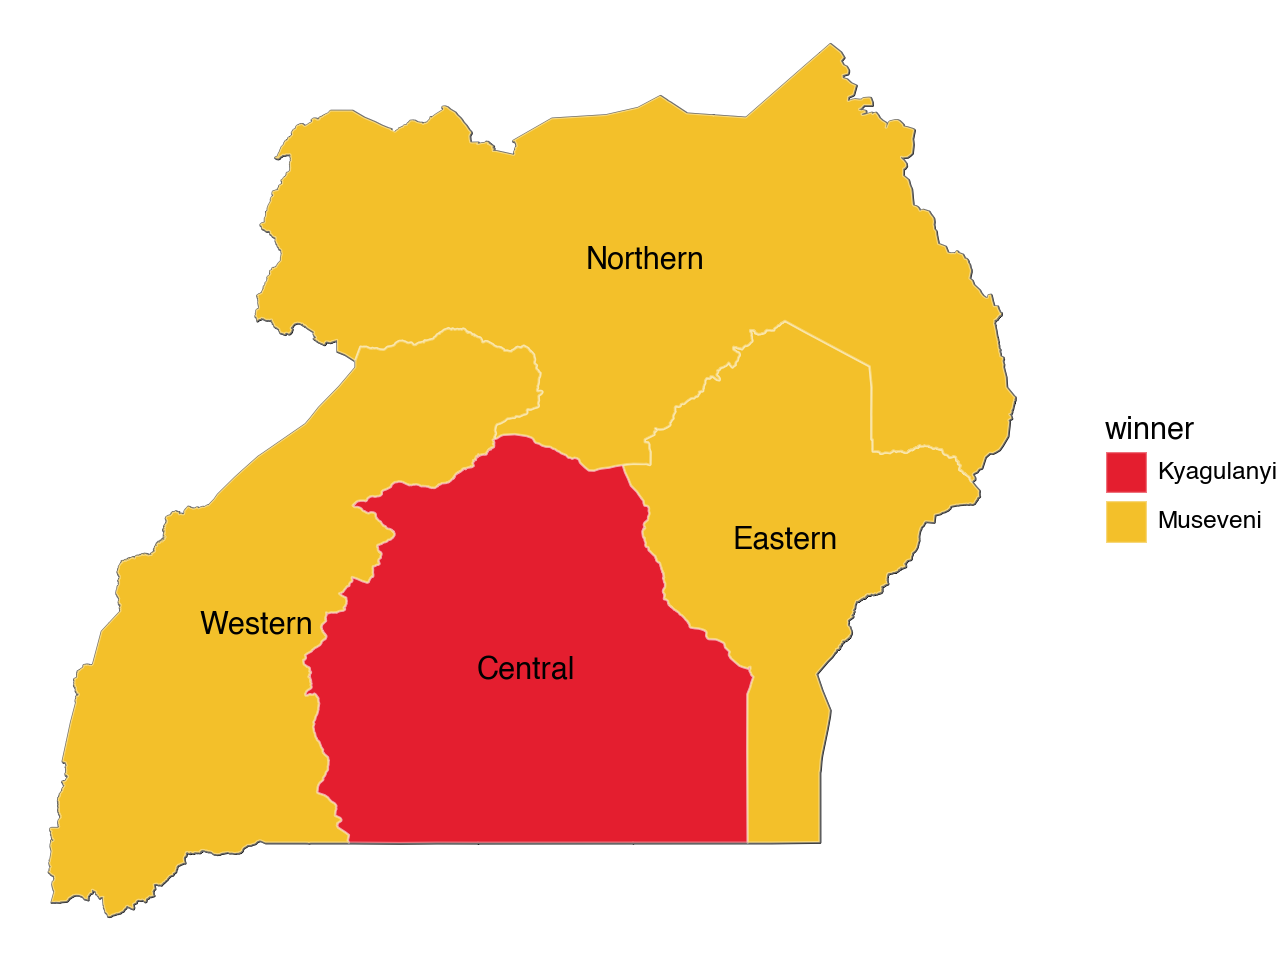

In [16]:
data = geo.regions.merge(results.regions_wide.to_pandas(), left_on="name", right_on="region")
display(data.head())
(
    ggplot(data)
    + geom_map(geo.national, fill="none")
    + geom_map(aes(fill="winner"), color="#FFFFFF60")
    + geom_text(aes("good_centroid(geometry).x", "good_centroid(geometry).y", label="name"))
    + scale_fill_candidate
    + theme_void()
)

### Winner per subregion

,name,code,region,geometry,subregion,Amuriat,Kabuleta,Kalembe,Katumba,Kyagulanyi,...,Muntu,Mwesigye,Tumukunde,Museveni,registered,valid,invalid,total,turnout,winner
0,Buganda,11,Central,"POLYGON ((31.11772 -0.59695, 31.12487 -0.58854...",Buganda,10836,2829,3712,6861,1528698,...,6825,2714,5170,876923,4338556,2450428,77684,2528112,58.270816,Kyagulanyi
1,Kampala,12,Central,"POLYGON ((32.51036 0.30728, 32.513 0.31265, 32...",Kampala,6608,1441,897,1698,391787,...,4795,202,433,128658,1258306,537980,12624,550604,43.757560,Kyagulanyi
2,Busoga,21,Eastern,"POLYGON ((33.078 0.55771, 33.07952 0.56299, 33...",Busoga,11268,2469,7548,2600,483886,...,2913,2113,3403,431070,1797607,950249,42646,992895,55.234264,Kyagulanyi
3,Bugisu,22,Eastern,"POLYGON ((34.4784 0.93333, 34.47148 0.91862, 3...",Bugisu,15397,733,1270,799,152076,...,751,1275,1312,251856,710120,426549,13909,440458,62.025855,Museveni
4,Bukedi,23,Eastern,"POLYGON ((33.91224 0.37494, 33.92082 0.37116, ...",Bukedi,24330,2917,2625,1766,206916,...,1842,1978,2673,313442,918426,561034,18947,579981,63.149454,Museveni


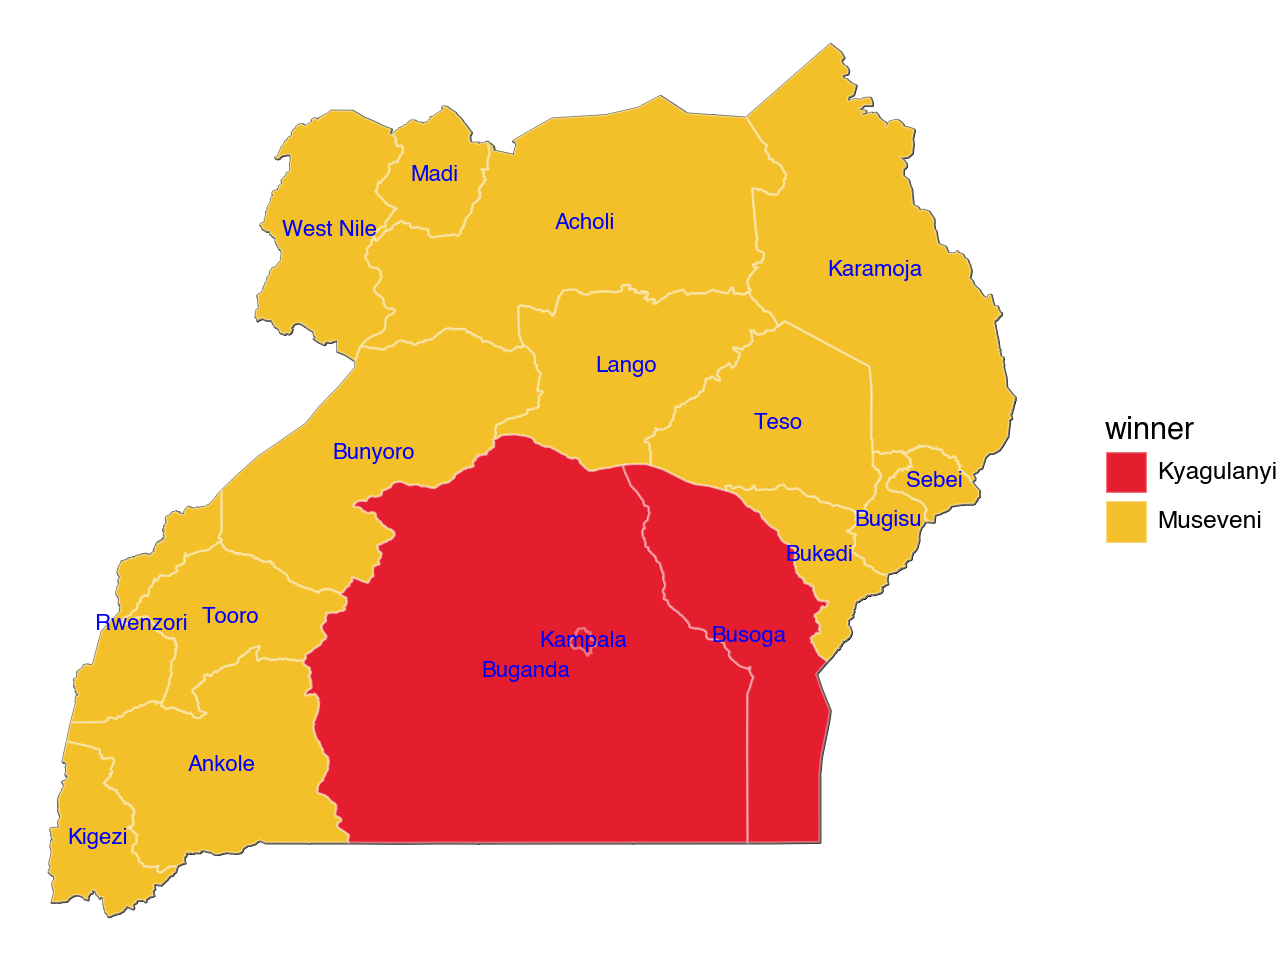

In [17]:
data =geo.subregions.merge(
    results.subregions_wide.to_pandas(),
    left_on=("region", "name"),
    right_on=("region", "subregion"),
)
display(data.head())
(
    ggplot(data)
    + geom_map(geo.national, fill="none")
    + geom_map(aes(fill="winner"), color="#FFFFFF60")
    + geom_text(
        aes("good_centroid(geometry).x", "good_centroid(geometry).y", label="name"),
        size=8,
        color="blue"
    )
    + scale_fill_candidate
    + theme_void()
)

### Winner per district

,name,code,region,subregion,id,geometry,district,Amuriat,Kabuleta,Kalembe,...,Muntu,Mwesigye,Tumukunde,Museveni,registered,valid,invalid,total,turnout,winner
0,Kalangala,101,Central,Buganda,None,"POLYGON ((31.9999 -0.99991, 32.00066 -0.39183,...",Kalangala,95,13,28,...,35,16,35,5275,35465,18741,1000,19741,55.663330,Kyagulanyi
1,Kampala,102,Central,Kampala,None,"POLYGON ((32.51036 0.30728, 32.513 0.31265, 32...",Kampala,6608,1441,897,...,4795,202,433,128658,1258306,537980,12624,550604,43.757560,Kyagulanyi
2,Kiboga,103,Central,Buganda,None,"POLYGON ((31.65462 0.81582, 31.65946 0.82183, ...",Kiboga,107,47,67,...,81,44,68,24254,81434,48577,2052,50629,62.171820,Museveni
3,Luweero,104,Central,Buganda,None,"POLYGON ((32.31995 0.56602, 32.32219 0.58217, ...",Luweero,459,176,256,...,298,184,211,41166,257115,147315,4649,151964,59.103514,Kyagulanyi
4,Masaka,105,Central,Buganda,None,"POLYGON ((31.65832 -0.4968, 31.6589 -0.49205, ...",Masaka,83,26,58,...,61,59,51,11317,55626,34961,1187,36148,64.984000,Kyagulanyi


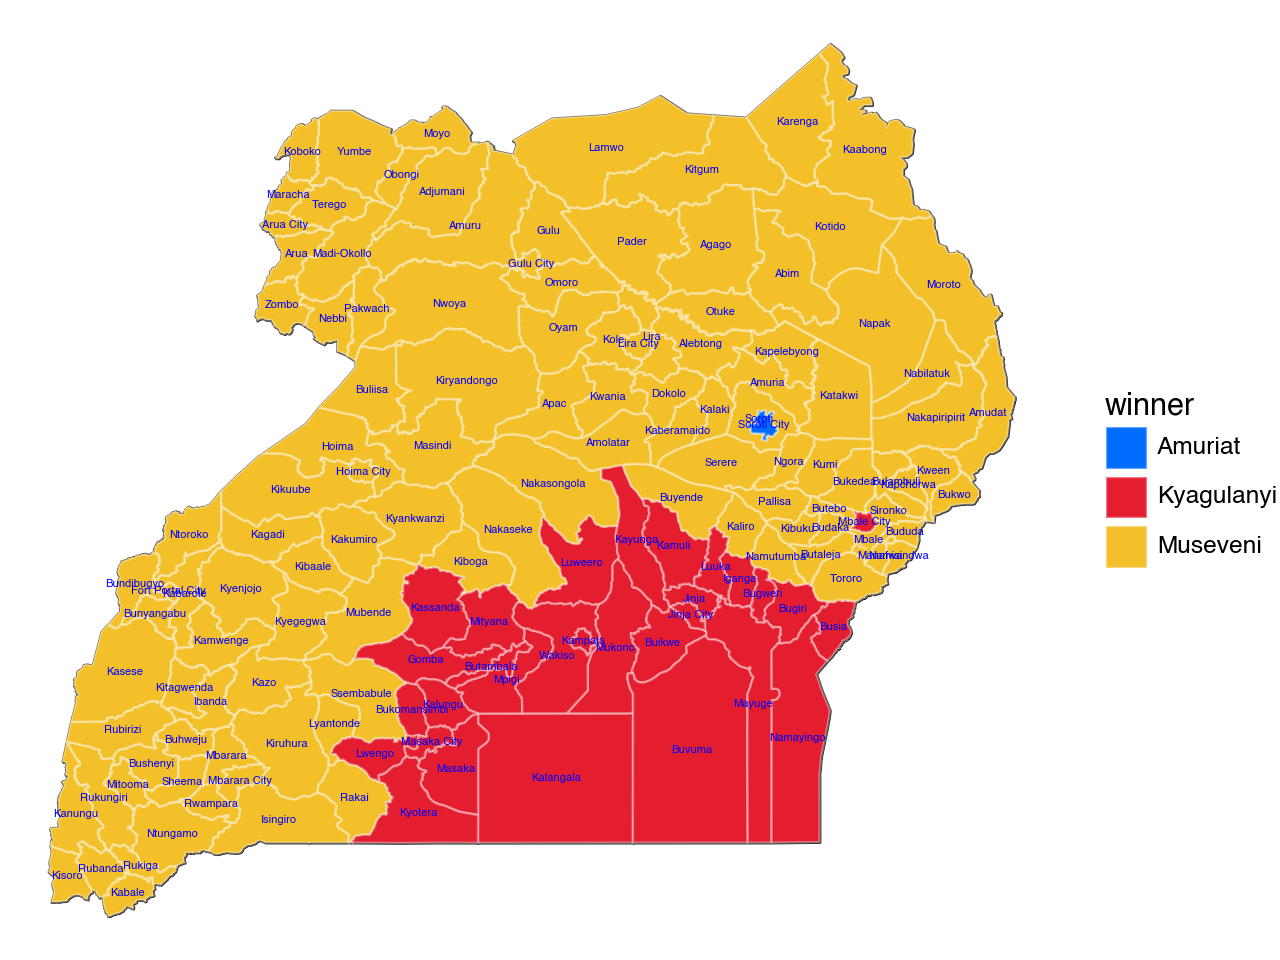

In [18]:
data =geo.districts.merge(
    results.districts_wide.to_pandas(),
    left_on=("region", "subregion", "name"),
    right_on=("region", "subregion", "district"),
)
display(data.head())
(
    ggplot(data)
    + geom_map(geo.national, fill="none")
    + geom_map(aes(fill="winner"), color="#FFFFFF60")
    + geom_text(
        aes("good_centroid(geometry).x", "good_centroid(geometry).y", label="name"),
        size=4,
        color="blue"
    )
    + scale_fill_candidate
    + theme_void()
)

### Winner per district (variable)

Try making varying the intensity of color in proportion to the winner's percentage of votes.

,name,code,region,subregion,id,geometry,district,Amuriat,Kabuleta,Kalembe,...,Mwesigye,Tumukunde,Museveni,registered,valid,invalid,total,turnout,winner,winner_pct
0,Kalangala,101,Central,Buganda,None,"POLYGON ((31.9999 -0.99991, 32.00066 -0.39183,...",Kalangala,95,13,28,...,16,35,5275,35465,18741,1000,19741,55.663330,Kyagulanyi,66.465731
1,Kampala,102,Central,Kampala,None,"POLYGON ((32.51036 0.30728, 32.513 0.31265, 32...",Kampala,6608,1441,897,...,202,433,128658,1258306,537980,12624,550604,43.757560,Kyagulanyi,71.155858
2,Kiboga,103,Central,Buganda,None,"POLYGON ((31.65462 0.81582, 31.65946 0.82183, ...",Kiboga,107,47,67,...,44,68,24254,81434,48577,2052,50629,62.171820,Museveni,47.905351
3,Luweero,104,Central,Buganda,None,"POLYGON ((32.31995 0.56602, 32.32219 0.58217, ...",Luweero,459,176,256,...,184,211,41166,257115,147315,4649,151964,59.103514,Kyagulanyi,68.293806
4,Masaka,105,Central,Buganda,None,"POLYGON ((31.65832 -0.4968, 31.6589 -0.49205, ...",Masaka,83,26,58,...,59,51,11317,55626,34961,1187,36148,64.984000,Kyagulanyi,63.992475


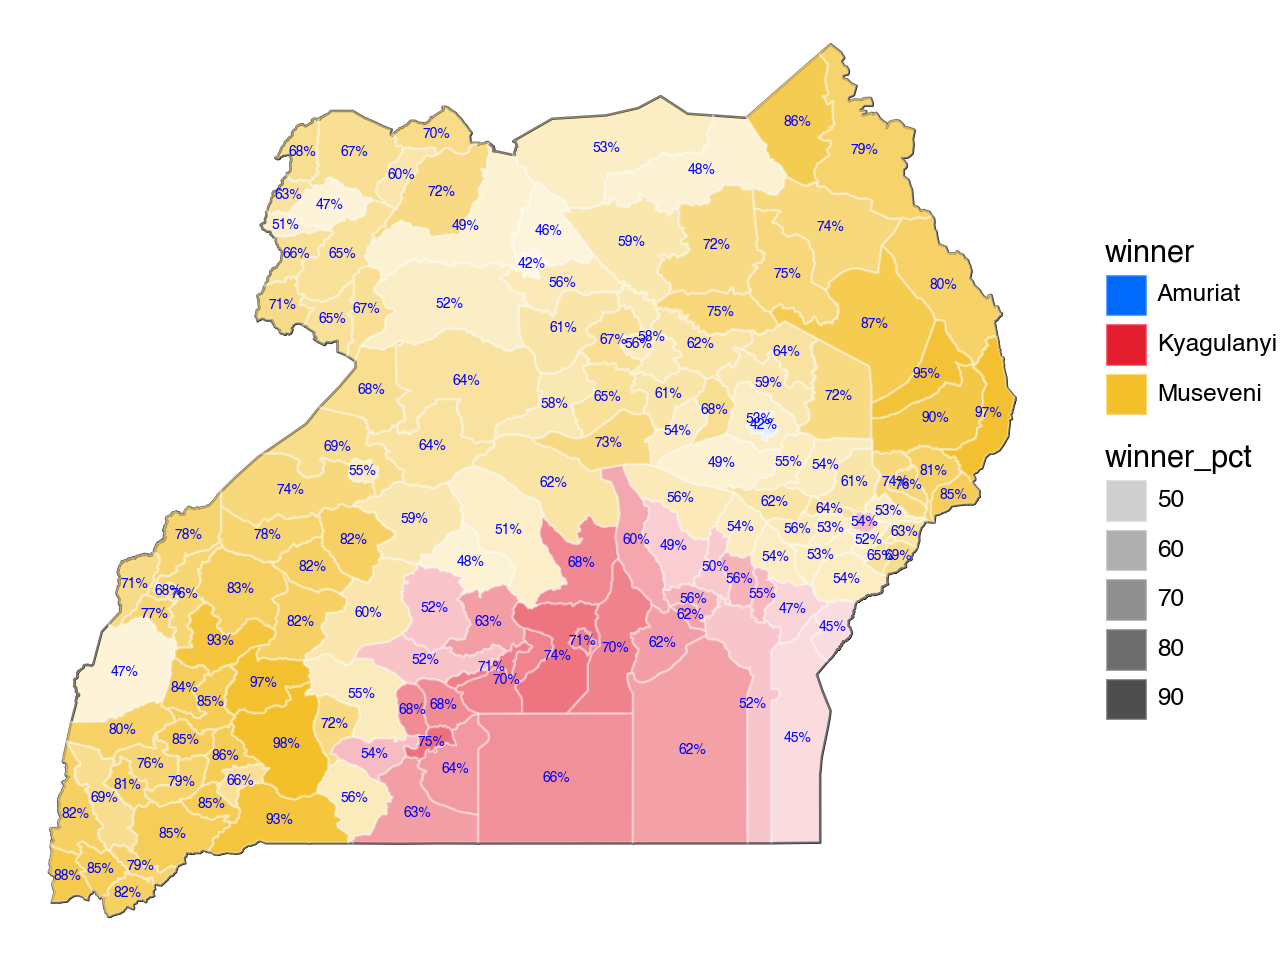

In [19]:
# Option 1: Map alpha to the winners vote percentage
# Pros: It is simple
# Cons: We get 2 legends, yet to the end user the information that
#       encoded in the gradient effect is a single variable.

winner_votes = column_lookup("winner", CANDIDATE_COLS, "winner_votes")

_df = results.districts_wide.with_columns(
    (winner_votes * 100 / pl.col.total).alias("winner_pct")
)

data =geo.districts.merge(
    _df.to_pandas(),
    left_on=("region", "subregion", "name"),
    right_on=("region", "subregion", "district"),
)

display(data.head())
(
    ggplot(data)
    + geom_map(geo.national, fill="white")
    + geom_map(aes(fill="winner", alpha="winner_pct"), color="#FFFFFF60")
    + geom_text(
        aes("good_centroid(geometry).x", "good_centroid(geometry).y", label="winner_pct"),
        size=5,
        color="blue",
        format_string="{:.0f}%"
    )
    + scale_fill_candidate
    + theme_void()
)

,name,code,region,subregion,id,geometry,district,Amuriat,Kabuleta,Kalembe,...,Tumukunde,Museveni,registered,valid,invalid,total,turnout,winner,winner_pct,winner_val
0,Kalangala,101,Central,Buganda,None,"POLYGON ((31.9999 -0.99991, 32.00066 -0.39183,...",Kalangala,95,13,28,...,35,5275,35465,18741,1000,19741,55.663330,Kyagulanyi,66.465731,166.465731
1,Kampala,102,Central,Kampala,None,"POLYGON ((32.51036 0.30728, 32.513 0.31265, 32...",Kampala,6608,1441,897,...,433,128658,1258306,537980,12624,550604,43.757560,Kyagulanyi,71.155858,171.155858
2,Kiboga,103,Central,Buganda,None,"POLYGON ((31.65462 0.81582, 31.65946 0.82183, ...",Kiboga,107,47,67,...,68,24254,81434,48577,2052,50629,62.171820,Museveni,47.905351,247.905351
3,Luweero,104,Central,Buganda,None,"POLYGON ((32.31995 0.56602, 32.32219 0.58217, ...",Luweero,459,176,256,...,211,41166,257115,147315,4649,151964,59.103514,Kyagulanyi,68.293806,168.293806
4,Masaka,105,Central,Buganda,None,"POLYGON ((31.65832 -0.4968, 31.6589 -0.49205, ...",Masaka,83,26,58,...,51,11317,55626,34961,1187,36148,64.984000,Kyagulanyi,63.992475,163.992475


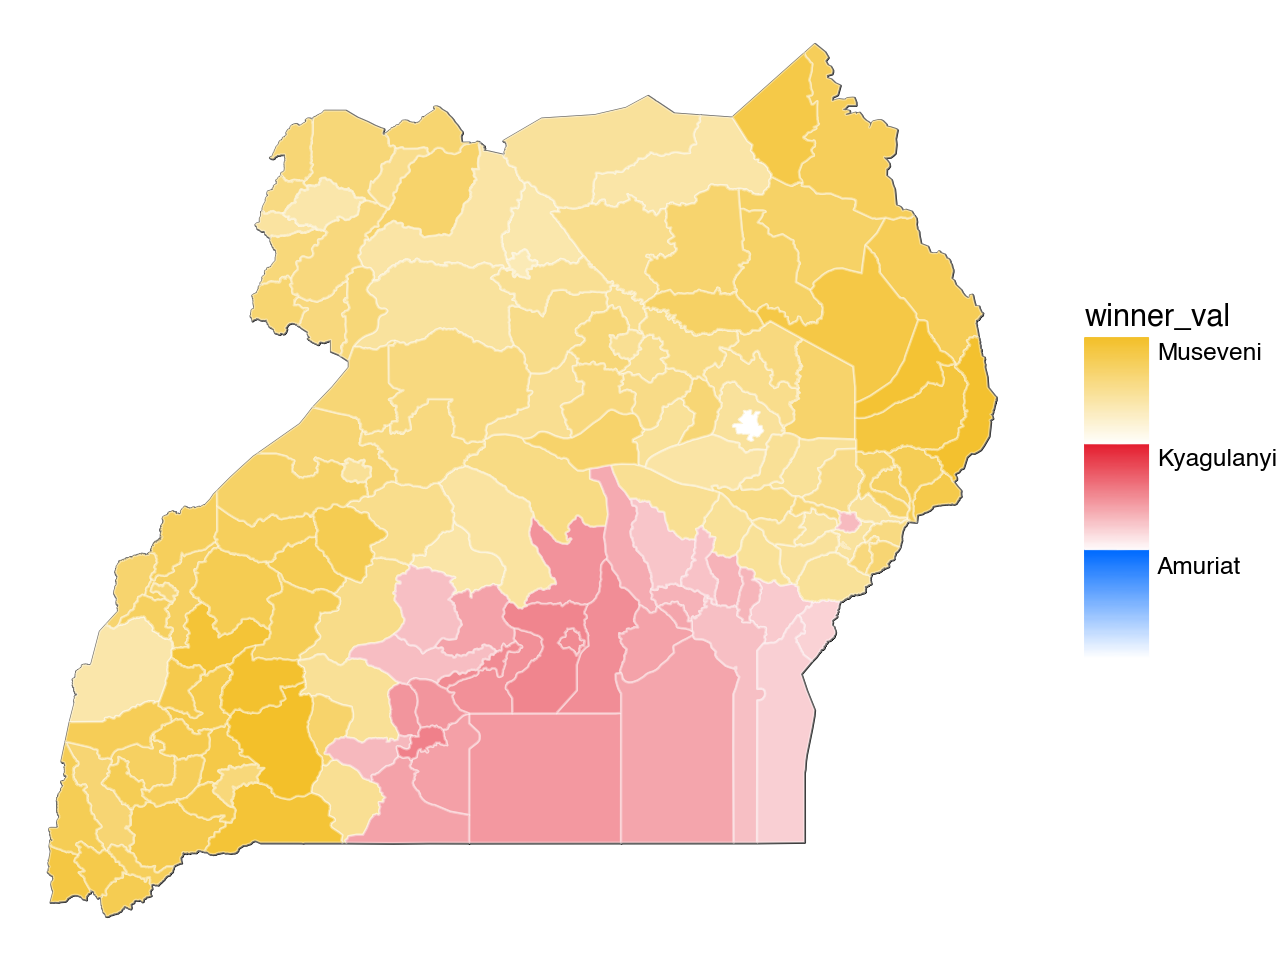

In [20]:
# Option 2: Map the fill to a continuous variable that encodes both
#           the winner and their percentage of votes
# Pros: Unified legend entries
# Cons: It is more complicated

# Task: Credit 3 continuous scales within one continuous
def _nextafter(f):
    import math
    return math.nextafter(f, float("inf"))
    
colors = [
    "white",
    candidate_colors["Amuriat"],
    "white",
    candidate_colors["Kyagulanyi"],
    "white",
    candidate_colors["Museveni"],
]
values = [0, 1/3, _nextafter(1/3), 2/3, _nextafter(2/3), 1]

scale_fill = scale_fill_gradientn(
        colors,
        values,
        breaks=[115, 200, 285],
        labels=["Amuriat", "Kyagulanyi", "Museveni"],
    )

def value_lookup(column, value_keys, values):
    expr = pl.lit(None)
    when = pl.when
    for k, v in zip(value_keys, values):
        expr = when(pl.col(column) == k).then(pl.lit(v))
        when = expr.when
    return expr

_df = results.districts_wide.with_columns(
    (winner_votes * 100 / pl.col.total).alias("winner_pct")
).with_columns(
    (pl.col.winner_pct + value_lookup("winner", ["Amuriat", "Kyagulanyi", "Museveni"], [0, 100, 200])).alias("winner_val")
)

data = geo.districts.merge(
    _df.to_pandas(),
    left_on=("region", "subregion", "name"),
    right_on=("region", "subregion", "district"),
)

display(data.head())
(
    ggplot(data)
    + geom_map(geo.national, fill="white")
    + geom_map(aes(fill="winner_val"), color="#FFFFFF60")
    + scale_fill
    + theme_void()
    + theme(legend_ticks=element_blank())
)